In [26]:
#Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import ast 
import seaborn as sns
from scipy.optimize import curve_fit
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import statsmodels.api as sm
from sympy import symbols, integrate, lambdify, diff
import scipy.integrate as spi
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import f_oneway, kruskal
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable


### Dataset Options: 

M4581_s1

In [27]:
csv_path = "/Users/alexandranava/Desktop/Spores/M4581_s1/Analysis/V3/M4581_s1_Model_Data.csv"
plots_folder = "/Users/alexandranava/Desktop/Spores/M4581_s1/Analysis/V3/Plots/"
time_between_frames = 5
framerange = [(0, 25), (25, 50), (50, 75), (75, 100), (100, 300)]
sample_germination_frames = [14, 38, 62, 86]
columns_to_scale = ['INTENSITY', 'AREA', 'GERMINANT EXPOSURE', 'GERMINATION',
                    'ELLIPSE MINOR', 'ELLIPSE MAJOR', 'PERIMETER', 'CIRCULARITY', "ELLIPSE ASPECT RATIO"]

M4581_s1_df  = scale_csv_data(csv_path, columns_to_scale)
#M4581_s1_df = pd.read_csv(csv_path) # use this one for unscaled df 
#Main(M4581_s1_df, plots_folder, time_between_frames)

M4576_s2

In [28]:
csv_path2 = "/Users/alexandranava/Desktop/Spores/M4576_s2/M4576_s2_Model_Data.csv"
plots_folder2 = "/Users/alexandranava/Desktop/Spores/M4576_s2/Analysis/Plots/"
time_between_frames2 = 5
framerange = [(0, 25), (25, 50), (50, 75), (75, 100), (100, 300)]
sample_germination_frames = [14, 38, 62, 86]

columns_to_scale = ['INTENSITY', 'AREA', 'GERMINANT EXPOSURE', 'GERMINATION',
                    'ELLIPSE MINOR', 'ELLIPSE MAJOR', 'PERIMETER', 'CIRCULARITY', "ELLIPSE ASPECT RATIO"]

M4576_s2_df  = scale_csv_data(csv_path2, columns_to_scale)

#M4567_s2_df = pd.read_csv(csv_path2) # use this one for unscaled df 
#Main(M4576_s2_df, plots_folder2, time_between_frames2)

All Spores

In [29]:
plots_folder_combined = "/Users/alexandranava/Desktop/Spores/M4581_s1andM4576_s2/plots/"

columns_to_scale = ['INTENSITY', 'AREA', 'GERMINANT EXPOSURE', 'GERMINATION',
                    'ELLIPSE MINOR', 'ELLIPSE MAJOR', 'PERIMETER', 'CIRCULARITY', "ELLIPSE ASPECT RATIO"]

M4581_s1_scaleddf  = scale_csv_data(csv_path, columns_to_scale)
M4567_s2_scaleddf = scale_csv_data(csv_path2, columns_to_scale)

df_stacked = pd.concat([M4581_s1_scaleddf, M4567_s2_scaleddf], axis=0)
df_stacked.reset_index(drop=True, inplace=True)

### Define Dataset to conduct analysis on: 

In [30]:
df = df_stacked 
combined_dataset = 1

---
# Analysis 

Normalize DataSet: 

In [31]:
def scale_csv_data(file_path: str, columns_to_scale: list[str]):
    data = pd.read_csv(file_path)
    scaler = MinMaxScaler()

    def scale_column(column):
        lists = column.apply(ast.literal_eval)
        flattened = np.concatenate(lists.values)
        scaled_flattened = scaler.fit_transform(flattened.reshape(-1, 1)).flatten()
        scaled_lists = []
        start = 0
        for lst in lists:
            end = start + len(lst)
            scaled_lists.append(scaled_flattened[start:end].tolist())
            start = end
        return [str(lst) for lst in scaled_lists]
    
    for column in columns_to_scale:
        data[column] = scale_column(data[column])

    return data

## Germination Measurement

Frame: 13, Frequency: 5
Frame: 14, Frequency: 5
Frame: 16, Frequency: 1
Frame: 37, Frequency: 24
Frame: 38, Frequency: 42
Frame: 39, Frequency: 2
Frame: 40, Frequency: 1
Frame: 57, Frequency: 3
Frame: 61, Frequency: 15
Frame: 62, Frequency: 21
Frame: 63, Frequency: 2
Frame: 64, Frequency: 1
Frame: 85, Frequency: 1
Frame: 86, Frequency: 6
Frame: 182, Frequency: 1
Percentages: [100, 96.15384615384616, 92.3076923076923, 91.53846153846153, 73.07692307692307, 40.76923076923077, 39.23076923076923, 38.46153846153847, 36.15384615384615, 24.615384615384617, 8.461538461538462, 6.923076923076923, 6.153846153846154, 5.384615384615385, 0.7692307692307693, 0.0]


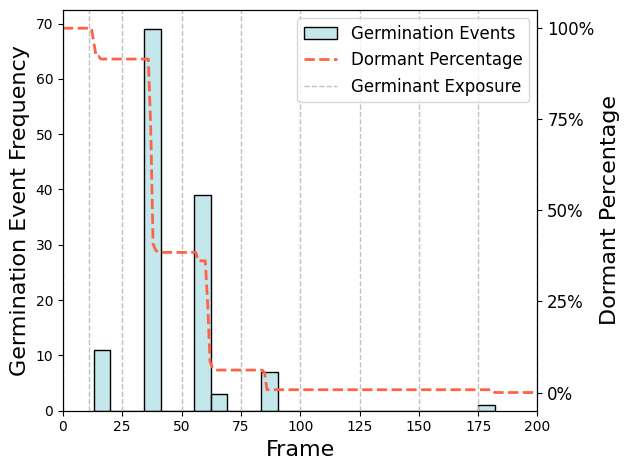

In [32]:
def germination_frequency(plots_folder: str, df, output: int = 1) -> None:

  GERMINATION: list[list] = df["GERMINATION"].apply(ast.literal_eval)
  germination_frames_list = GERMINATION.apply(lambda x: x.index(1)) #list of germination frames as indices
  frames_shown: int = 200

  #print times frame germination occurs
  frame_counts = Counter(germination_frames_list)
  sorted_frame_counts = sorted(frame_counts.items())
  for frame_number, count in sorted_frame_counts:
      if output == 1:
        print(f"Frame: {frame_number}, Frequency: {count}")
      
  #histogram plot 
  fig, ax1 = plt.subplots()
  bin_number = 24
  #germinant intervals
  ax1.grid(color='silver', linewidth=1, linestyle = "dashed", which = "both", axis = "x")
  #histogram
  sns.histplot(germination_frames_list, bins = bin_number, label = f"Germination Events", ax = ax1, color = "powderblue")
  #axis labels 
  ax1.set_xlabel("Frame", fontsize = 16)
  ax1.set_ylabel("Germination Event Frequency", fontsize = 16)
  #x axis limit and ticks
  ax1.set_xlim([0, frames_shown])
 
  #overlaid percentage plot 
  total_spores = sum(count for frame, count in sorted_frame_counts)
  spores_count = total_spores
  frames = [0]
  percents = [100]
  percent_plot = [100]
  frame_dict = dict(sorted_frame_counts)

  percent = 100  

  for frame_number in range(1, frames_shown+1):
    if frame_number in frame_dict:
      count = frame_dict[frame_number]
      spores_count -= count
      percent = spores_count / total_spores * 100
      percent_plot.append(percent)
    percents.append(percent)
    frames.append(frame_number)

  #percent plot
  ax2 = ax1.twinx()
  sns.lineplot(x=frames, y=percents, ax = ax2, linestyle = "--", linewidth = 2, label = "Dormant Percentage", color = "tomato")

  #custom germinant label
  ax2.axvline(x=11, color='silver', label='Germinant Exposure', linewidth = 1, linestyle = "dashed")

  #percent y axis formatting
  ax2.set_ylabel("Dormant Percentage", fontsize = 16)
  ax2.set_yticks([0, 25, 50, 75, 100])
  ax2.tick_params(axis='y', labelsize=12)
  ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{int(y)}%'))
  
  #legends
  handles1, labels1 = ax1.get_legend_handles_labels()
  handles2, labels2 = ax2.get_legend_handles_labels()
  ax2.legend(handles=handles1 + handles2, labels=labels1 + labels2, loc='best', fontsize=12)


  plt.tight_layout()
  plt.savefig(plots_folder + "germination_percentage.jpg")
  print(f"Percentages: {percent_plot}")

### function call
germination_frequency(plots_folder, df)

## Feature Analysis

Get minimum and maximum global value of a given feature

In [33]:
def get_min_max(df, feature: str) -> int:
    data_max = []
    data_min = []
    data = df[feature].apply(ast.literal_eval) 
    for row in data:
        data_max.append(max(row))
        data_min.append(min(row))
    return [min(data_min), max(data_max)]

In [34]:
minmax_intensity: list[int, int] = get_min_max(df, "INTENSITY")
minmax_area: list[int, int] = get_min_max(df, "AREA")
minmax_minor: list[int, int] = get_min_max(df, "ELLIPSE MINOR")
minmax_major: list[int, int] = get_min_max(df, "ELLIPSE MAJOR")
minmax_perimeter: list[int, int] = get_min_max(df, "PERIMETER")
minmax_circularity: list[int, int] = get_min_max(df, "CIRCULARITY")
minmax_aspectratio: list[int, int] = get_min_max(df, "ELLIPSE ASPECT RATIO")

Feature Values for different measures: 
[AVERAGE, INITIAL, LAST, DIFFERENCE]

In [35]:
def feature_values(df, feature: str):
  '''
  takes in a FEATURE and GERMINATION and returns avg feature, initial value of feature, and last value of feature (all before germination), as well as difference
  return is [avg, initial, last, difference] 
  each array has format:
  np array [[spore1_germination frame, spore1_featurevalue], 
            [spore2_germination frame, spore2_featurevalue],
            ...]
  '''

  FEATURE = df[feature].apply(ast.literal_eval)
  GERMINATION = df["GERMINATION"].apply(ast.literal_eval)

  avg_germination_feature = []
  initial_germination_feature = []
  last_germination_feature = []
  diff_feature = []

  df['Germination Frame'] = GERMINATION.apply(lambda x: x.index(1)) #get germination frame where first "1" occurs 

  for i in range(len(df)):
    spore_feature = FEATURE[i]
    spore_germination_frame = df.loc[i, "Germination Frame"]
    feature_before_germination = spore_feature[0: spore_germination_frame] # does not include germination frame 


    avg_feature = np.mean(feature_before_germination)
    initial_feature = np.mean(feature_before_germination[0: 11]) #averaged over first and last frames
    last_feature = np.mean(feature_before_germination[-5: -1])

    avg_germination_feature.append(np.array([spore_germination_frame, avg_feature]))
    initial_germination_feature.append(np.array([spore_germination_frame, initial_feature]))
    last_germination_feature.append(np.array([spore_germination_frame, last_feature]))
    diff_feature.append(np.array([spore_germination_frame, last_feature - initial_feature]))

  return [np.array(avg_germination_feature), np.array(initial_germination_feature), np.array(last_germination_feature), np.array(diff_feature)]

In [36]:
intensity_arrays = feature_values(df, "INTENSITY")
area_arrays = feature_values(df, "AREA")
minor_arrays = feature_values(df, "ELLIPSE MINOR")
major_arrays = feature_values(df, "ELLIPSE MAJOR")
aspect_arrays = feature_values(df, "ELLIPSE ASPECT RATIO")
perimeter_arrays = feature_values(df, "PERIMETER")
circularity_arrays = feature_values(df, "CIRCULARITY")

Swarmplot of germination frame and feature values

In [64]:
def subplot_swarmplot(arrays, subplot_title, min_max, framerange, show_plots=1):
    avg_array, initial_array, last_array, diff_array = arrays

    array_labels = ["Average", "Initial", "Last", "Difference"]
    for array_index, array in enumerate(arrays):
      if array_index == len(array_labels):
          min_max = [0, 1]
      fig, axs = plt.subplots(1,1,figsize = (4, 4))
      palette = sns.color_palette("pastel", len(framerange))

      data = pd.DataFrame(array, columns=['Germination Frame', 'Value'])
      data['Germination Frame'] = data['Germination Frame'].astype(int)  # Convert to integers
      for j, frames in enumerate(framerange):
          group_indices = data['Germination Frame'].between(frames[0], frames[1])
          color = palette[j]
          sns.boxplot(x='Germination Frame', y='Value', data=data[group_indices], ax=axs, color=color, width=0.8)
          sns.swarmplot(x='Germination Frame', y='Value', data=data[group_indices], ax=axs, color=color, edgecolor='black', size=2)
      
      axis_fontsize = 8
      axs.set_xlabel(f"Germination Frame", fontsize = axis_fontsize)
      axs.set_ylim(min_max)
      axs.tick_params(axis='x', labelsize=6)  # Change x-axis tick size
      axs.tick_params(axis='y', labelsize=6)  # Change y-axis tick size
      #axis font size     
      axs.set_ylabel(f"{array_labels[array_index]} {subplot_title}", fontsize = axis_fontsize)
      #legend
      for j, frames in enumerate(framerange):
          if j != len(framerange)-1:
              color = palette[j]
              axs.plot([], [], 'o', label=f'Germinant Exposure: {j+1}', color=color, markersize=5)
          if j == len(framerange)-1:
              color = palette[len(framerange)-1]
              axs.plot([], [], 'o', label=f'Germinant Exposure: {8}', color=color, markersize=5) ########## HARDCODED


      axs.legend(fontsize = 8, loc = "best", shadow = True)

      plt.tight_layout()
      plt.savefig(f"{plots_folder}boxplots_swarmplots_{array_labels[array_index]}_{subplot_title}.jpg")
      plt.close()

In [65]:
subplot_swarmplot(intensity_arrays, "Electrochemical Potential", minmax_intensity, framerange)
subplot_swarmplot(area_arrays, "Size", minmax_area, framerange)
subplot_swarmplot(minor_arrays, "Ellipse Minor", minmax_minor, framerange)
subplot_swarmplot(minor_arrays, "Ellipse Major", minmax_major, framerange, 0)
subplot_swarmplot(aspect_arrays, "Ellipse Aspect Ratio", minmax_aspectratio, framerange, 0)
subplot_swarmplot(perimeter_arrays, "Perimeter", minmax_perimeter, framerange, 0)
subplot_swarmplot(circularity_arrays, "Circularity", minmax_circularity, framerange, 0)

Sample of feature behaviors over time

In [62]:
def plot_feature_example(feature_column_title, feature: str, frames: list[int]):
    GERMINATION = df["GERMINATION"].apply(ast.literal_eval)
    FEATURE = df[feature_column_title].apply(ast.literal_eval)

    #plot initializing
    plt.clf()
    palette = sns.color_palette('Spectral', n_colors=len(frames))
    custom_handles = []
    spore_labels = []
    plt.figure(figsize=(12,8))

    #germinant intervals
    for frame in frames[0:5]:
      plt.axvline(x = frame - 1, color='silver', linestyle='--', linewidth = 2) 
    custom_handles.append(plt.Line2D([0], [0], color='silver', linestyle='dashed', label="Germinant Exposure", linewidth = 2))

    #---
    for frame in frames[:: -1]: 
      tmp = 0
      for spore_index, feature_row in enumerate(FEATURE):
        germination_frame = GERMINATION.iloc[spore_index].index(1)
        if germination_frame == frame:
          tmp += 1
          if tmp == 3:
            frame_index = frames.index(frame)
            colorline = palette[frame_index % len(palette)]
            #before germination
            sns.lineplot(x=range(germination_frame), y=feature_row[:germination_frame], linewidth=10, color = colorline, label = f"Spore {frame_index + 1}")#, label=f'Germinated at L-alanine Exposure {frames.index(frame) + 1}', )
            #after germination
            sns.lineplot(x = range(germination_frame-1, len(feature_row)), y=feature_row[germination_frame-1:], linestyle = '-', color = colorline, linewidth = 3)
            #legend for spore labels
            custom_handles.append(plt.Line2D([0], [0], color=colorline, lw=4, linestyle='None', marker='o', label=f"Spore {frame_index + 1}"))
            spore_labels.append((f"Spore {frame_index + 1}", colorline))  
            break  

    #axis fonts size
    axis_fontsize = 32
    plt.xlabel('Frame', fontsize=axis_fontsize) 
    plt.ylabel(f"{feature}", fontsize=axis_fontsize)  
   
    #axis ticks and limits
    plt.xticks(fontsize = 20)  
    plt.yticks(fontsize = 20)
   # plt.xlim(0, 95)
    plt.ylim(0, 1)

    #legend
    custom_handles = custom_handles[::-1]
    plt.legend(handles=custom_handles, loc='best', shadow = True, fontsize=20)  
    plt.tight_layout(rect=[0, 0, 0.85, 1])  

    plt.savefig(f"{plots_folder}sample_{feature}.jpg")
    plt.close()

In [63]:
plot_feature_example("INTENSITY", "Electrochemical Potential", sample_germination_frames)
plot_feature_example("AREA", "Size", sample_germination_frames)
plot_feature_example("ELLIPSE MINOR", "Ellipse Minor", sample_germination_frames)
plot_feature_example("ELLIPSE MAJOR", "Ellipse Major", sample_germination_frames)
plot_feature_example("PERIMETER", "Perimeter", sample_germination_frames)
plot_feature_example("CIRCULARITY", "Circularity", sample_germination_frames)
plot_feature_example("ELLIPSE ASPECT RATIO", "Ellipse Aspect Ratio", sample_germination_frames)

<Figure size 640x480 with 0 Axes>

# Feature Relationships

### Heatmap between Features

In [53]:
def feature_heatmap(df, features_list, plot_title, custom_labels, bold_labels):
  '''takes in df in format where each row denotes a spore and each column is a feature and each cell is feature over time in a list'''
  plt.clf()

  correlation_matrices = []

  for spore_index in range(len(df)):
    spore_features = []
    for feature in features_list:
      spore_feature = ast.literal_eval(df.loc[spore_index, feature])
      spore_features.append(spore_feature)
    spore_df = pd.DataFrame(spore_features).T
    spore_df.columns = features_list

    spore_feature_correlation = spore_df.corr()
    #heatmap for individual spore: 
    #sns.heatmap(spore_feature_correlation, annot = True, vmin = 0, vmax = 1, cmap = "coolwarm")
    
    #heatmap for all spores: 
    correlation_matrices.append(spore_feature_correlation)
  
  avg_correlation_matrix = np.mean(correlation_matrices, axis=0)
  avg_correlation_df = pd.DataFrame(avg_correlation_matrix, index=features_list, columns=features_list)
  avg_correlation_df.rename(columns=custom_labels, index=custom_labels, inplace=True)

  # Plot the heatmap for the average correlation matrix
  plt.figure(figsize = ((14,13)))
  ax = sns.heatmap(avg_correlation_df, annot=True, vmin=0, vmax=1, cmap="coolwarm", 
                   xticklabels=True, yticklabels=True, annot_kws={"size": 15}, #numbers in heatmap
                   cbar_kws={'label': 'Pearson Correlation Coefficient'}, cbar = False)

  ax.set_aspect('equal')

  # Customize tick labels
  for tick in ax.get_xticklabels():
      if bold_labels and tick.get_text() in bold_labels:
          tick.set_weight('bold')
      tick.set_fontsize(24) #labels size
  
  for tick in ax.get_yticklabels():
      if bold_labels and tick.get_text() in bold_labels:
          tick.set_weight('bold')
      tick.set_fontsize(24)
      
  #padding between labels and heatmap
  ax.tick_params(axis='x', pad=10)
  ax.tick_params(axis='y', pad=10)

  #colorbar with the same height as the heatmap
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.5)
  cbar = plt.colorbar(ax.collections[0], cax=cax)

  # Customize colorbar label size
  cbar.ax.tick_params(labelsize=20)
  cbar.ax.yaxis.label.set_size(25)
  cbar.ax.yaxis.label.set_text('Pearson Correlation Coefficient')
  cbar.ax.yaxis.labelpad = 15

  #save
  plt.tight_layout()
  plt.savefig(f"{plots_folder + plot_title}.jpg")

<Figure size 640x480 with 0 Axes>

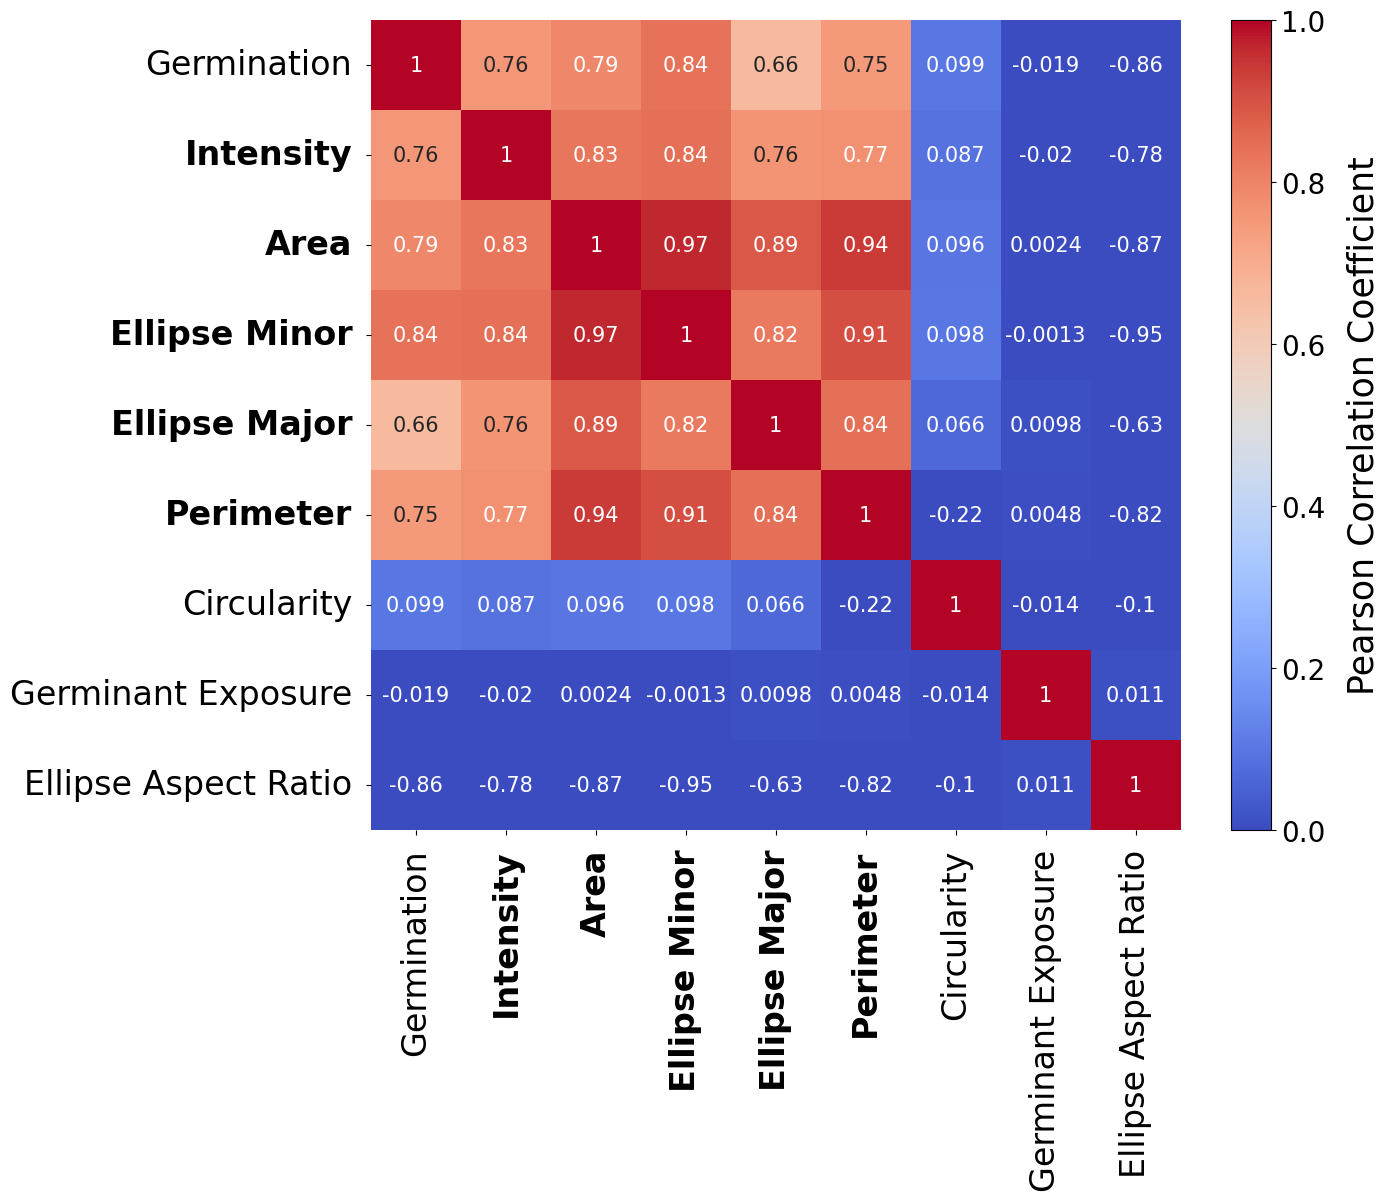

In [54]:
# feature heatmap call 
heatmap_labels = {
  'GERMINATION': 'Germination',
  'INTENSITY': 'Intensity',
  "AREA": "Area",
  "ELLIPSE MINOR": "Ellipse Minor",
  "ELLIPSE MAJOR": "Ellipse Major",
  "PERIMETER": "Perimeter",
  "CIRCULARITY": "Circularity",
  "GERMINANT EXPOSURE": "Germinant Exposure",
  "ELLIPSE ASPECT RATIO": "Ellipse Aspect Ratio"
  }
features = ["GERMINATION", "INTENSITY", "AREA", "ELLIPSE MINOR", "ELLIPSE MAJOR", "PERIMETER", "CIRCULARITY", "GERMINANT EXPOSURE", "ELLIPSE ASPECT RATIO"]
bold_labels = ["Intensity", "Area", "Ellipse Minor", "Ellipse Major", "Perimeter"]
feature_heatmap(df, features, "Feature Correlations over Time", heatmap_labels, bold_labels)
  

Scatter plot features against eachother

In [72]:
def scatter_features(FEATURE1_ARRAYS, FEATURE2_ARRAYS, features_list: list[str]):

  array_labels = ["Average", "Initial", "Last", "Difference"]
  for array_index in range(len(FEATURE1_ARRAYS)):
    FEATURE1 = FEATURE1_ARRAYS[array_index]
    FEATURE2 = FEATURE2_ARRAYS[array_index]
    
  #for spore_index, spore_row in range(len(FEATURE1)):
    plt.figure(figsize = (6,6))
    germination_frame = FEATURE1[:, 0]
    feature1 = FEATURE1[:, 1]
    feature2 = FEATURE2[:, 1]
    scatter = plt.scatter(feature1, feature2, c = germination_frame, cmap = "turbo", s  = 60, edgecolor = "black")
    plt.colorbar(scatter)
    plt.grid()
    plt.xlabel(f"{array_labels[array_index]} {features_list[0]}", fontsize = 16)
    plt.ylabel(f"{array_labels[array_index]} {features_list[1]}", fontsize = 16)
    plt.savefig(f"{plots_folder}scatterplot_{array_labels[array_index]}_{features_list[0]}_against{features_list[1]}.jpg")
    plt.show()

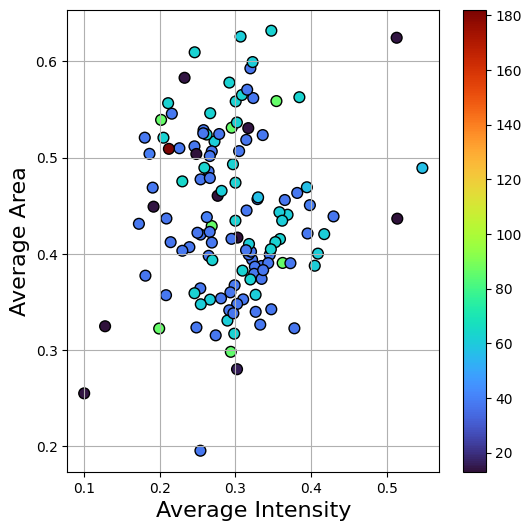

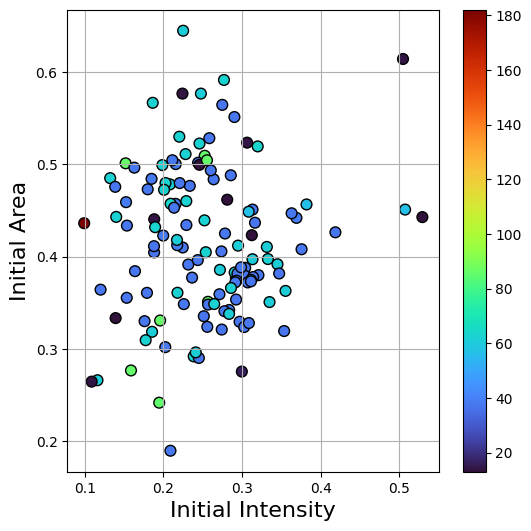

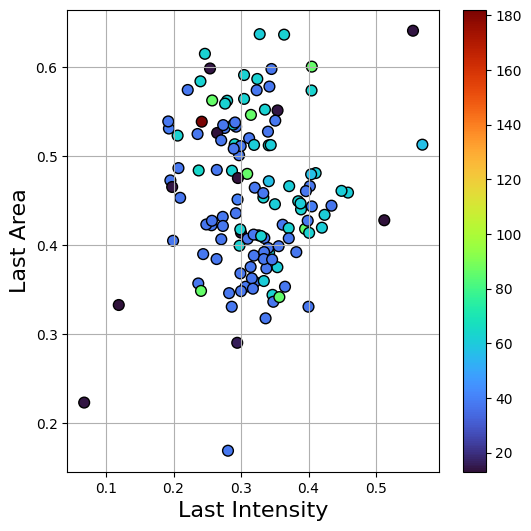

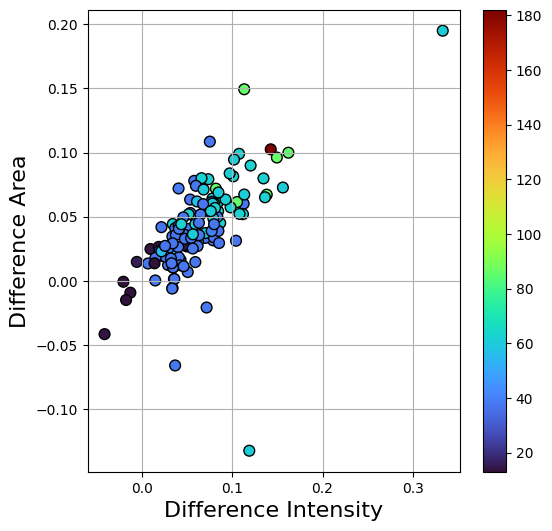

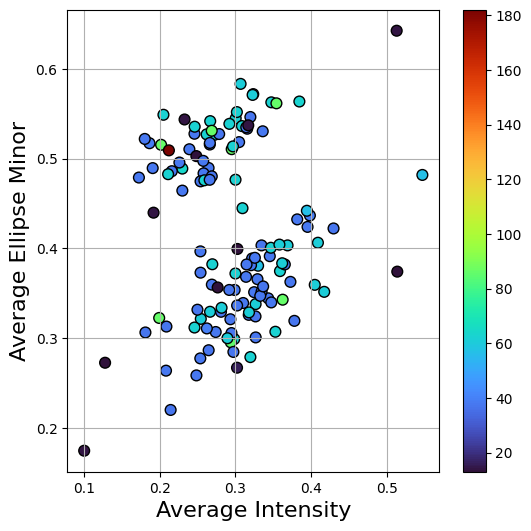

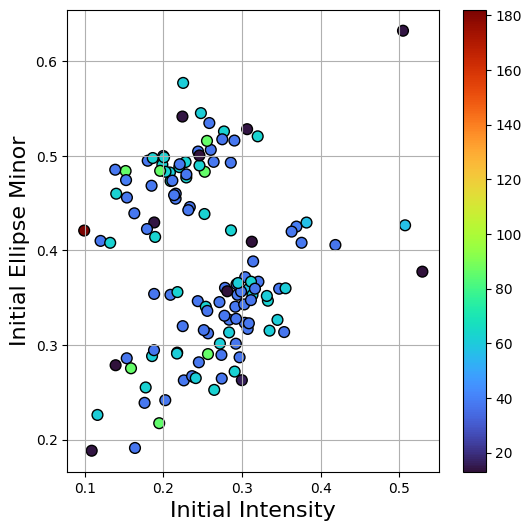

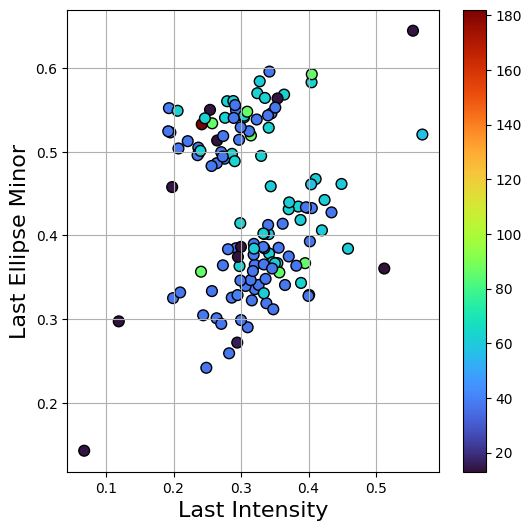

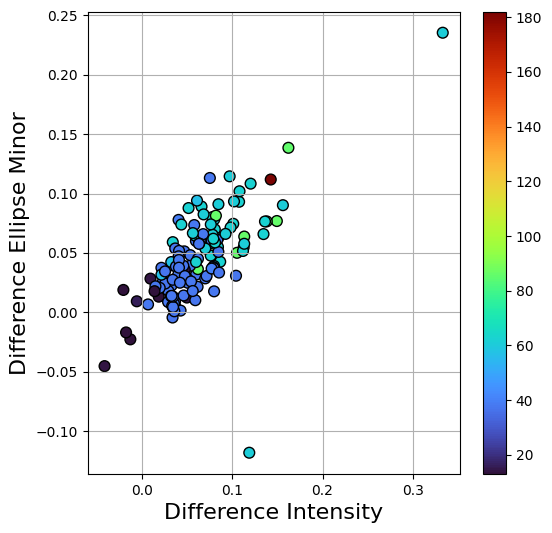

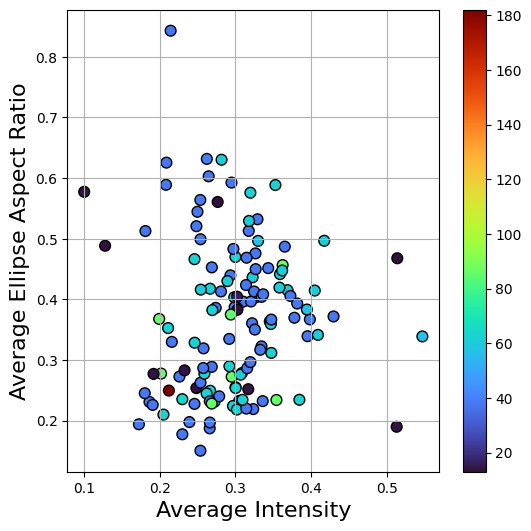

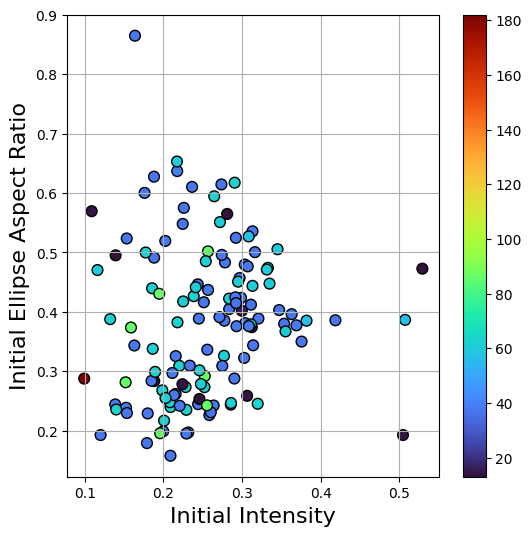

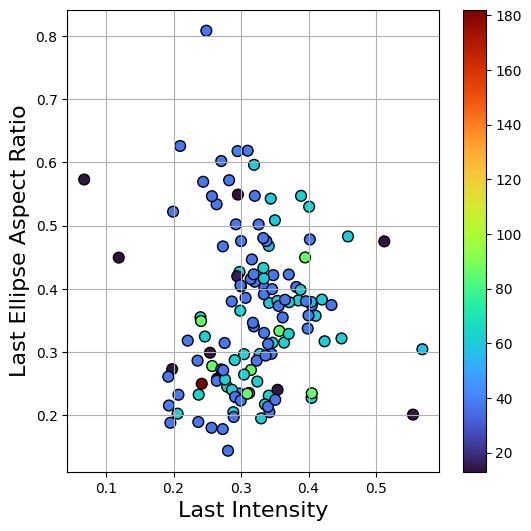

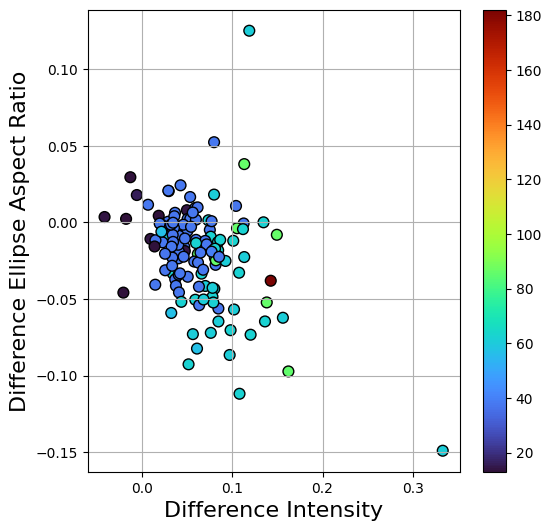

In [74]:
scatter_features(intensity_arrays, area_arrays, ["Intensity", "Area"])
scatter_features(intensity_arrays, minor_arrays, ["Intensity", "Ellipse Minor"])
scatter_features(intensity_arrays, aspect_arrays, ["Intensity", "Ellipse Aspect Ratio"])

### Signal Integration

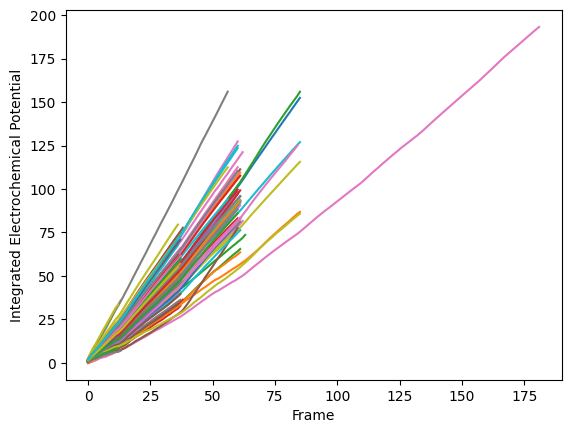

In [39]:
def sum_intensity(df, time_between_frames: int):
  '''summed intensity takes in GERMINATION and INTENSITY as pd.Series
  and sums intensity over time and plots each sum as a function of time
  '''
  df

  GERMINATION = df["GERMINATION"].apply(ast.literal_eval)
  INTENSITY = df["INTENSITY"].apply(ast.literal_eval)


  summed_intensity_allspores = []
  #iterate through spores
  for spore_index, spore_row in enumerate(INTENSITY):
    germination_frame = GERMINATION.apply(lambda x: x.index(1))
    summed_intensity: int = 0 

    #summed intensity at each timestep for each spore 
    summed_intensities: list[int] = []
    #iterate through intensity list of a given spore
    for intensity_index, intensity_value in enumerate(spore_row[0: int(germination_frame[spore_index])]):
      summed_intensity += intensity_value * time_between_frames
      summed_intensities.append(summed_intensity)
    summed_intensity_allspores.append(summed_intensities)
  
  sum_intensity_df = pd.DataFrame(summed_intensity_allspores)

  #plot 
  plt.xlabel("Frame")
  plt.ylabel("Integrated Electrochemical Potential")
  for row_index in range(len(sum_intensity_df)):
    row = list(sum_intensity_df.iloc[row_index, :])
    xs = range(len(row))
    sns.lineplot(x = xs, y = row)
  plt.savefig(f"{plots_folder}time_summation.jpg")
sum_intensity(df, time_between_frames)

### Spatial Dynamics

Plot values of the location within the image frame, with color denoting germination time

In [40]:
def plot_xy_germinationframe(df):  
  '''
  plots x and y location with germination frame as z value 
  '''
  df['Germination Frame'] = df["GERMINATION"].apply(lambda x: x.index(1)) #get germination frame where first "1" occurs 

  plt.figure(figsize=(6, 3))
  #plot
  scatter = plt.scatter(df['X_POSITION'], df['Y_POSITION'], c = df['Germination Frame'], cmap = 'gist_ncar', s=30)
  plt.colorbar(scatter, label='Germination Frame')
  plt.xlabel('X')
  plt.ylabel('Y')

  plt.gca().invert_yaxis()
  plt.title('Spores by Germination Frame')
  plt.grid(True)
  plt.savefig(f"{plots_folder}germinationframe_location.jpg")

  plt.clf()
  
if combined_dataset != 1:
  plot_xy_germinationframe(df)